<a href="https://colab.research.google.com/github/bismillahkani/ISL-CV-Team3/blob/master/ASL_Interpretation_using_Fastai2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Set-up - Load libraries & packages

In [2]:
# Let's first download a utility file for setting up Google Colab
!wget https://raw.githubusercontent.com/WittmannF/course-v4/master/utils/colab_utils.py

--2020-05-01 13:10:05--  https://raw.githubusercontent.com/WittmannF/course-v4/master/utils/colab_utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1214 (1.2K) [text/plain]
Saving to: ‘colab_utils.py.1’

colab_utils.py.1    100%[===================>]   1.19K  --.-KB/s    in 0s      

2020-05-01 13:10:05 (77.4 MB/s) - ‘colab_utils.py.1’ saved [1214/1214]



In [3]:
from colab_utils import setup_fastai_colab
setup_fastai_colab()

    NOTE: For debugging and visualizing stdout, please run:
    from colab_utils import *
    !{REQUIREMENTS_PIP}
    !{GIT_CLONE_REPOSITORY}
    %cd {FASTAI_NB_PATH}

Installing requirements...
Done!
Cloning FastAI Repository...
Done!
Opening folder course-v4/nbs/ with nbs and utils files...
Done!


In [0]:
#hide
from utils import *
from fastai2.vision import *
from fastai2.vision.all import *
from fastai2.vision.widgets import *

### Dataset

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
import zipfile

local_zip = '/content/drive/My Drive/ISL/asl-alphabet.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/')
zip_ref.close()

In [0]:
dataset_path = '/tmp/asl_alphabet_train/'
image_paths=[image_path for image_path in glob.glob(dataset_path+'/*/*/*')]
image_categories=[os.path.basename(os.path.dirname(image_path)) for image_path in image_paths]
filenames=[os.path.basename(image_path) for image_path in image_paths]

In [6]:
dataset_df = pd.DataFrame({'image_paths':image_paths,'filename':filenames,'image_category':image_categories})
dataset_df.sort_values('image_category',inplace=True)
dataset_df.head()

,image_paths,filename,image_category
81000,/tmp/asl_alphabet_train/asl_alphabet_train/A/A34.jpg,A34.jpg,A
82996,/tmp/asl_alphabet_train/asl_alphabet_train/A/A29.jpg,A29.jpg,A
82997,/tmp/asl_alphabet_train/asl_alphabet_train/A/A1284.jpg,A1284.jpg,A
82998,/tmp/asl_alphabet_train/asl_alphabet_train/A/A484.jpg,A484.jpg,A
82999,/tmp/asl_alphabet_train/asl_alphabet_train/A/A2830.jpg,A2830.jpg,A


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


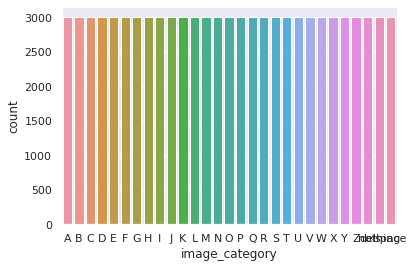

In [7]:
import seaborn as sns
sns.set(style="darkgrid")
ax = sns.countplot(x="image_category", data=dataset_df)

In [0]:
path = '/tmp/asl_alphabet_train/asl_alphabet_train'

In [9]:
fns = get_image_files(path)
fns

(#87000) [Path('/tmp/asl_alphabet_train/asl_alphabet_train/L/L1374.jpg'),Path('/tmp/asl_alphabet_train/asl_alphabet_train/L/L2653.jpg'),Path('/tmp/asl_alphabet_train/asl_alphabet_train/L/L327.jpg'),Path('/tmp/asl_alphabet_train/asl_alphabet_train/L/L1493.jpg'),Path('/tmp/asl_alphabet_train/asl_alphabet_train/L/L2015.jpg'),Path('/tmp/asl_alphabet_train/asl_alphabet_train/L/L2088.jpg'),Path('/tmp/asl_alphabet_train/asl_alphabet_train/L/L938.jpg'),Path('/tmp/asl_alphabet_train/asl_alphabet_train/L/L2959.jpg'),Path('/tmp/asl_alphabet_train/asl_alphabet_train/L/L2409.jpg'),Path('/tmp/asl_alphabet_train/asl_alphabet_train/L/L1948.jpg')...]

In [10]:
failed = verify_images(fns)
failed

(#0) []

In [0]:
failed.map(Path.unlink);

In [0]:
asl = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(224))

In [0]:
dls = asl.dataloaders(path)

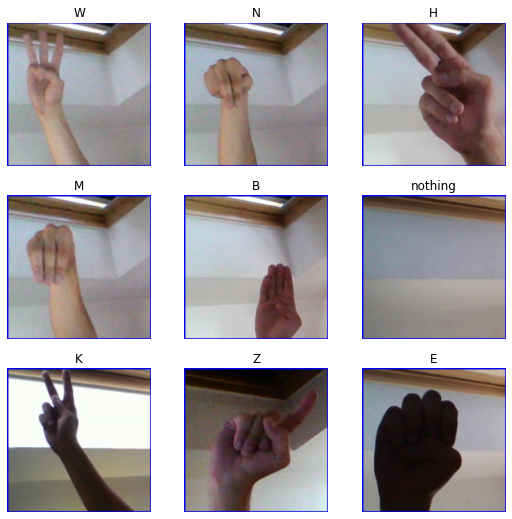

In [14]:
dls.train.show_batch(max_n=9)

### Model training

*RESNET*

In [0]:
learn = cnn_learner(dls, resnet34, metrics=[error_rate,accuracy])

In [16]:
learn.fine_tune(epochs=1, base_lr=1e-3, freeze_epochs=2)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.299396,0.096537,0.025402,0.974598,07:28
1,0.059118,0.012372,0.003218,0.996782,07:31


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.002334,0.000206,0.000115,0.999885,10:21


### Results

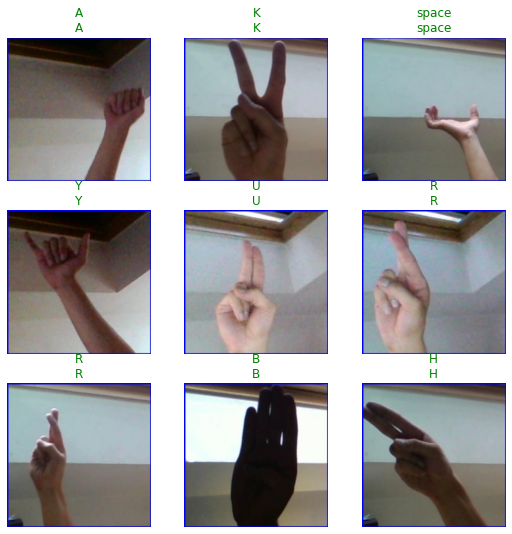

In [18]:
learn.show_results()

In [0]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [0]:
interp.plot_top_losses(9, figsize=(15,10))

In [0]:
interp.print_classification_report()

### Model inference

In [0]:
learn.export('export_asl.pkl')